# Analysis of Price Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.spatial.distance import jensenshannon
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# Import required functionalities from capoptix
from capoptix.data_loader import DataLoader
from capoptix.energymarkets.wholesale_energy_markets import DAM
from capoptix.utils import check_and_handle_missing_data, box_plotting

## Data Source for Analysis:
we will be using the dataset provided by [Open Power System Data](https://data.open-power-system-data.org/time_series/2020-10-06). This dataset contains comprehensive time series data for electricity production, consumption, and other relevant variables for various European countries.

### Key Features of the Dataset:
- **Time series data** for energy generation, consumption, and prices.
- Covers **multiple European countries**, (Here we use Austria for our analysis).
- Includes data on **renewable energy sources** such as solar and wind generation.

This dataset is well-suited for analyzing energy market trends, modeling capacity options, and developing robust financial models to evaluate energy market instruments.

In [3]:
data = DataLoader(filepath="time_series_15min_singleindex_filtered.csv").load_data()
data.head()

,timestamps,cet_cest_timestamp,consumption,AT_load_forecast_entsoe_transparency,prices,solar_generation,wind_generation,hour,day,month,year,minutes
0,2015-01-01 07:15:00+00:00,2015-01-01T08:15:00+0100,6349.6,7058.95,28.22,1.16,105.16,7,1,1,2015,15
1,2015-01-01 07:30:00+00:00,2015-01-01T08:30:00+0100,6348.4,7064.16,43.98,1.74,105.92,7,1,1,2015,30
2,2015-01-01 07:45:00+00:00,2015-01-01T08:45:00+0100,6488.0,7111.87,44.62,2.66,111.55,7,1,1,2015,45
3,2015-01-01 08:00:00+00:00,2015-01-01T09:00:00+0100,6675.2,7154.72,36.60,5.43,119.47,8,1,1,2015,0
4,2015-01-01 08:15:00+00:00,2015-01-01T09:15:00+0100,6867.2,7237.49,35.40,8.21,146.12,8,1,1,2015,15


In [4]:
prices = DAM(data,scale=True).get_market_data()
prices.head()

0    28.22
1    43.98
2    44.62
3    36.60
4    35.40
Name: prices, dtype: float64

In [5]:
# Focus on the price data and the timestamps for the time-being
analyzedata = data[["timestamps","year","month","hour","day","minutes"]]
analyzedata["prices"] = prices

/var/folders/t4/gd0ch0vd2d9gfydnl1mwjj7c0000gn/T/ipykernel_1522/3561773866.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analyzedata["prices"] = prices


In [6]:
analyzedata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201570 entries, 0 to 201569
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype              
---  ------      --------------   -----              
 0   timestamps  201570 non-null  datetime64[ns, UTC]
 1   year        201570 non-null  int64              
 2   month       201570 non-null  int64              
 3   hour        201570 non-null  int64              
 4   day         201570 non-null  int64              
 5   minutes     201570 non-null  int64              
 6   prices      131350 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(1), int64(5)
memory usage: 10.8 MB


In [7]:
analyzedata = check_and_handle_missing_data(analyzedata, columns='prices', trendfill=True)
analyzedata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131386 entries, 0 to 131577
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype              
---  ------      --------------   -----              
 0   timestamps  131386 non-null  datetime64[ns, UTC]
 1   year        131386 non-null  int64              
 2   month       131386 non-null  int64              
 3   hour        131386 non-null  int64              
 4   day         131386 non-null  int64              
 5   minutes     131386 non-null  int64              
 6   prices      131386 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(1), int64(5)
memory usage: 8.0 MB


/Users/millendroy/Projects/CapOptix/capoptix/capoptix/utils.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(streak, inplace=True)
/Users/millendroy/Projects/CapOptix/capoptix/capoptix/utils.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(streak, inplace=True)
/Users/millendroy/Projects/CapOptix/capoptix/capoptix/utils.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

In [8]:
analyzedata["prices"].describe()

count    131386.000000
mean         34.130155
std          15.822449
min           0.000000
25%          23.950000
50%          33.000000
75%          43.000000
max         115.052080
Name: prices, dtype: float64

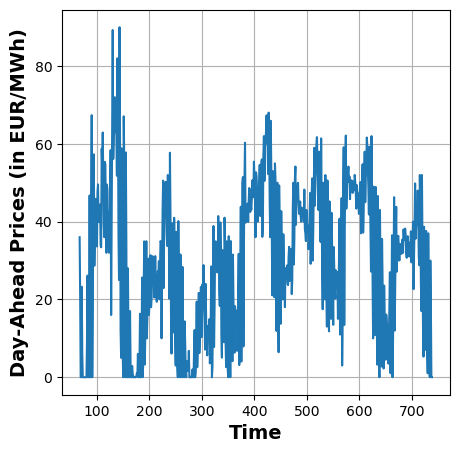

In [9]:
plt.figure(figsize=(5,5))
plt.plot(analyzedata["prices"][67:67+96*7*1])
tick_positions = []
tick_labels = []
plt.ylabel("Day-Ahead Prices (in EUR/MWh)", fontsize= 14, fontweight='bold')
plt.xlabel("Time", fontsize = 14, fontweight='bold')
plt.grid()
plt.show()

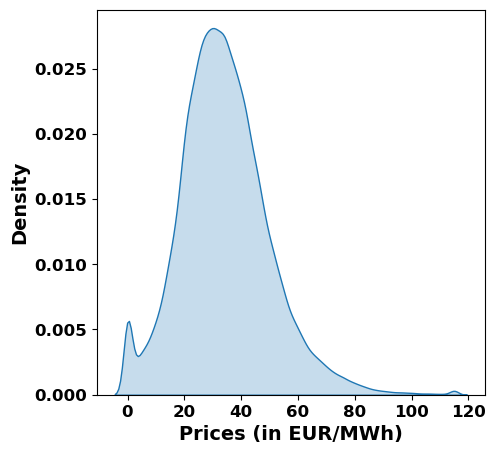

In [10]:
plt.figure(figsize=(5,5))
sns.kdeplot(analyzedata, x= 'prices', fill= True)
plt.xlabel("Prices (in EUR/MWh)", fontsize= 14, fontweight='bold')
plt.ylabel("Density", fontsize = 14, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.show()

## 1. Analyzing Yearly

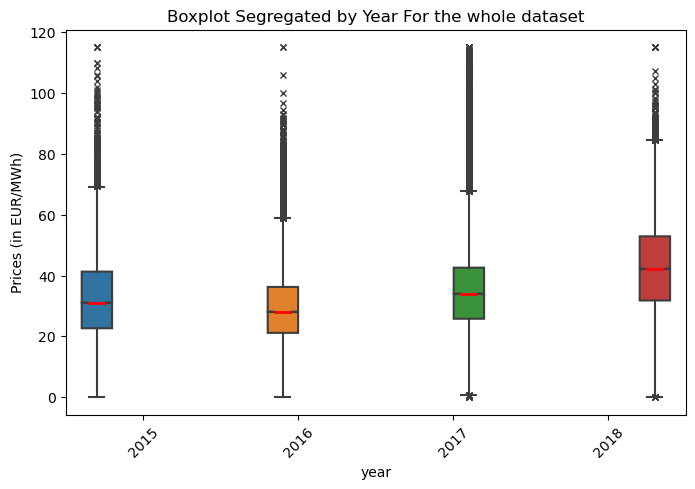

In [11]:
box_plotting(
    data_x = 'year',
    data_y = 'prices',
    data_hue = 'year',
    dataframe = analyzedata,
    title = 'Boxplot Segregated by Year For the whole dataset',
    xlabel = 'year',
    ylabel = 'Prices (in EUR/MWh)',
    figgsize=(8,5)
    )

## 2. Analyzing Monthly

In [12]:
month_mapping = {
    1:"Jan",
    2:"Feb",
    3:"Mar",
    4:"Apr",
    5:"May",
    6:"Jun",
    7:"Jul",
    8:"Aug",
    9:"Sep",
    10:"Oct",
    11:"Nov",
    12:"Dec"
}
analyzedata['month'] = analyzedata['month'].replace(month_mapping)

/var/folders/t4/gd0ch0vd2d9gfydnl1mwjj7c0000gn/T/ipykernel_1522/3687168248.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analyzedata['month'] = analyzedata['month'].replace(month_mapping)


In [13]:
analyzedata["month"].value_counts()

Mar    11904
May    11904
Jul    11904
Aug    11904
Jan    11683
Apr    11520
Jun    11520
Sep    11520
Feb    10848
Oct     9111
Dec     8928
Nov     8640
Name: month, dtype: int64

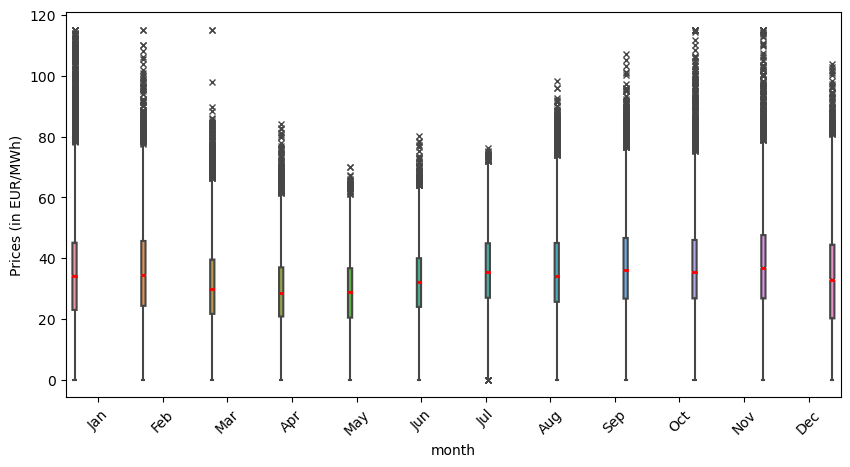

In [14]:
box_plotting(
    data_x = 'month',
    data_y = 'prices',
    data_hue = 'month',
    dataframe = analyzedata,
    title = '',
    xlabel = 'month',
    ylabel = 'Prices (in EUR/MWh)',
    )

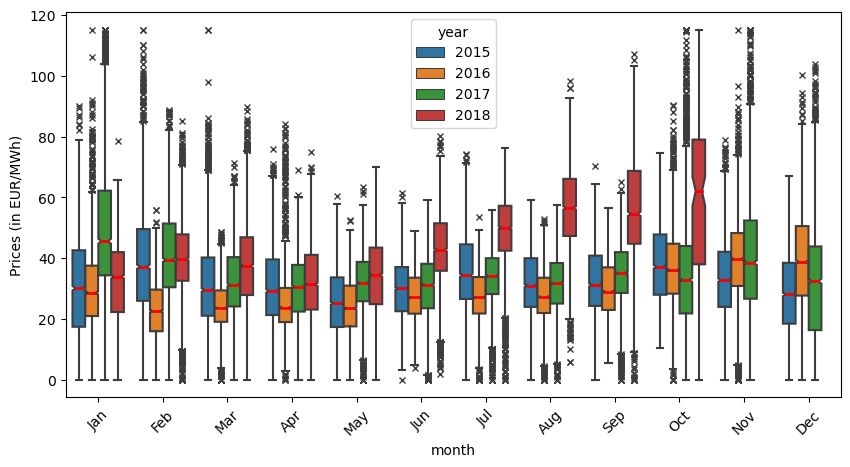

In [15]:
box_plotting(
    data_x = 'month',
    data_y = 'prices',
    data_hue = 'year',
    dataframe = analyzedata,
    title = '',
    xlabel = 'month',
    ylabel = 'Prices (in EUR/MWh)',
    legend_notreq= False
    )

## 3.Analyzing Weekly

In [16]:
analyzedata['week_number'] = analyzedata['timestamps'].dt.isocalendar().week
analyzedata["week_number"].value_counts()

/var/folders/t4/gd0ch0vd2d9gfydnl1mwjj7c0000gn/T/ipykernel_1522/36877929.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analyzedata['week_number'] = analyzedata['timestamps'].dt.isocalendar().week


27    2688
29    2688
22    2688
23    2688
24    2688
25    2688
26    2688
2     2688
28    2688
30    2688
39    2688
31    2688
32    2688
33    2688
34    2688
35    2688
36    2688
37    2688
21    2688
20    2688
19    2688
18    2688
3     2688
5     2688
6     2688
7     2688
8     2688
9     2688
10    2688
11    2688
12    2688
13    2688
14    2688
15    2688
16    2688
17    2688
38    2688
4     2496
1     2371
40    2199
41    2016
42    2016
43    2016
44    2016
45    2016
46    2016
47    2016
48    2016
49    2016
50    2016
51    2016
52    2016
53     672
Name: week_number, dtype: Int64

In [17]:
analyzedata['day_of_week'] = analyzedata['timestamps'].dt.day_name()
analyzedata["day_of_week"].value_counts()

/var/folders/t4/gd0ch0vd2d9gfydnl1mwjj7c0000gn/T/ipykernel_1522/3179461427.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analyzedata['day_of_week'] = analyzedata['timestamps'].dt.day_name()


Saturday     18816
Sunday       18816
Monday       18816
Tuesday      18803
Thursday     18783
Friday       18724
Wednesday    18628
Name: day_of_week, dtype: int64

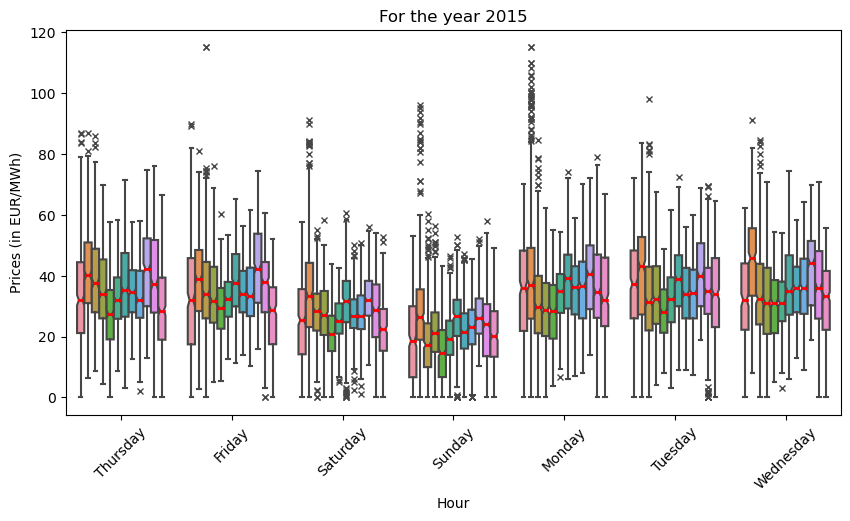

In [18]:
box_plotting(
    data_x = 'day_of_week',
    data_y = 'prices',
    data_hue = 'month',
    dataframe = analyzedata[analyzedata["year"]==2015],
    title = 'For the year 2015',
    xlabel = 'Hour',
    ylabel = 'Prices (in EUR/MWh)',
    # legend_notreq=False
    )


## 4. Analyzing Hourly

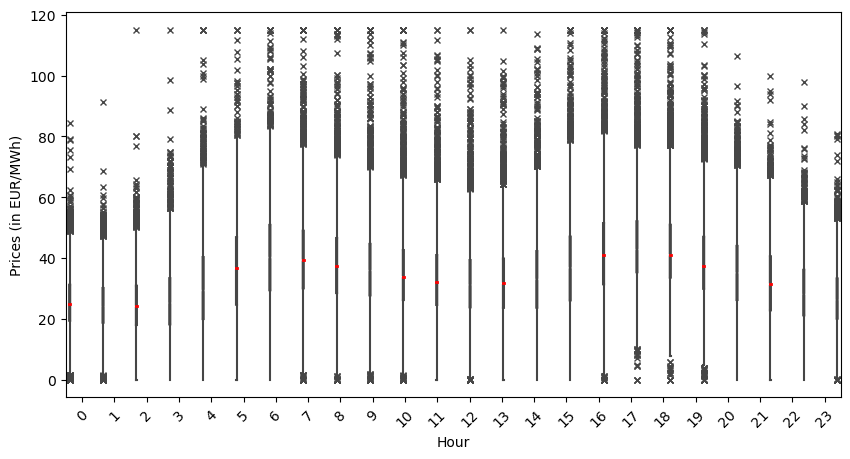

In [19]:
box_plotting(
    data_x = 'hour',
    data_y = 'prices',
    data_hue = 'hour',
    dataframe = analyzedata,
    title = '',
    xlabel = 'Hour',
    ylabel = 'Prices (in EUR/MWh)'
    )

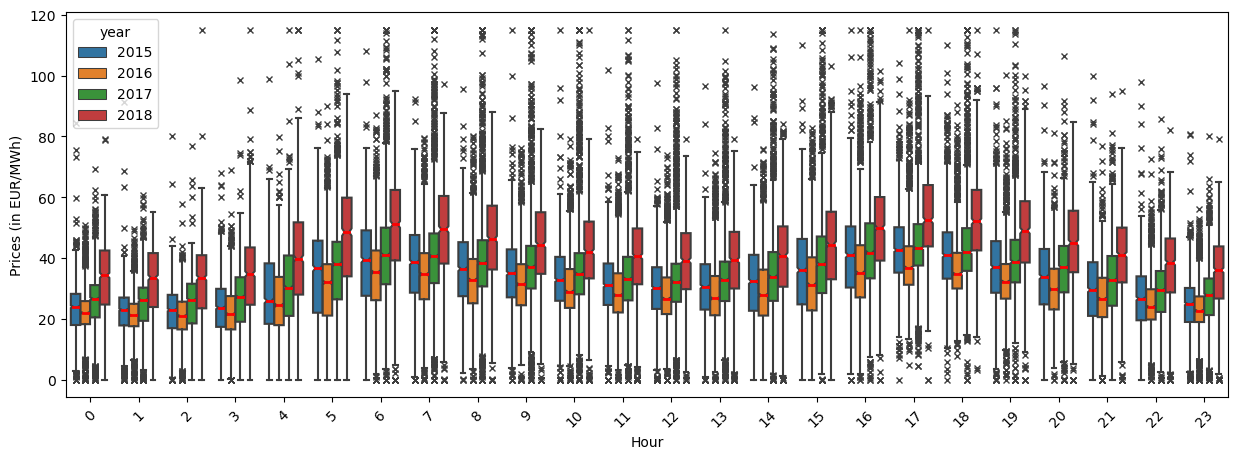

In [20]:
box_plotting(
    data_x = 'hour',
    data_y = 'prices',
    data_hue = 'year',
    dataframe = analyzedata,
    title = '',
    xlabel = 'Hour',
    ylabel = 'Prices (in EUR/MWh)',
    legend_notreq=False,
    figgsize=(15,5)
    )

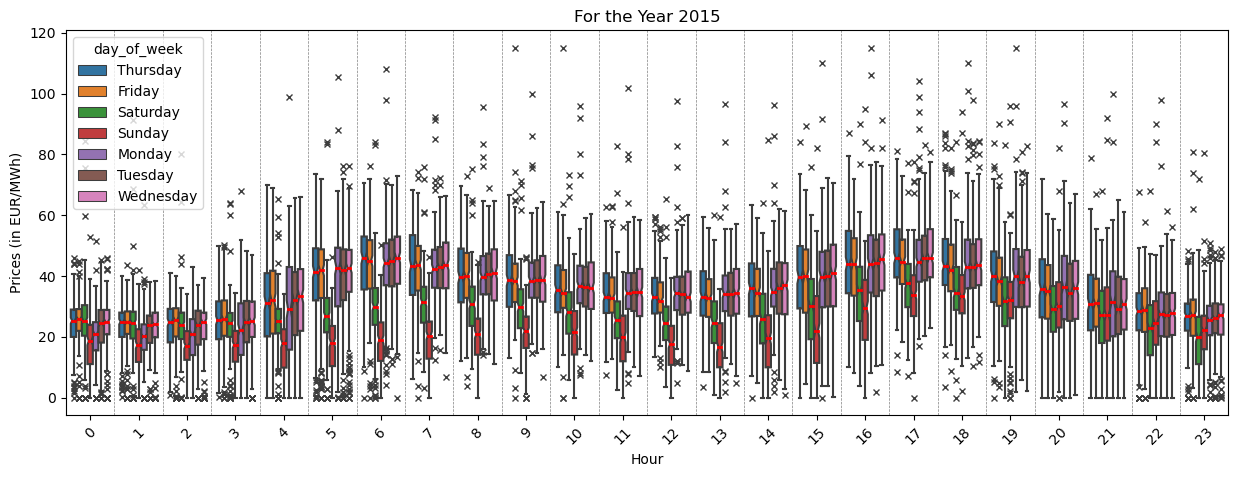

In [21]:
box_plotting(
    data_x = 'hour',
    data_y = 'prices',
    data_hue = 'day_of_week',
    dataframe = analyzedata[analyzedata["year"]==2015],
    title = 'For the Year 2015',
    xlabel = 'Hour',
    ylabel = 'Prices (in EUR/MWh)',
    legend_notreq=False,
    figgsize=(15,5),
    verticalline=True
    )


/var/folders/t4/gd0ch0vd2d9gfydnl1mwjj7c0000gn/T/ipykernel_1522/2765322299.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels, fontproperties=fm.FontProperties(weight='bold', size=8))  # Make y-ticks bold


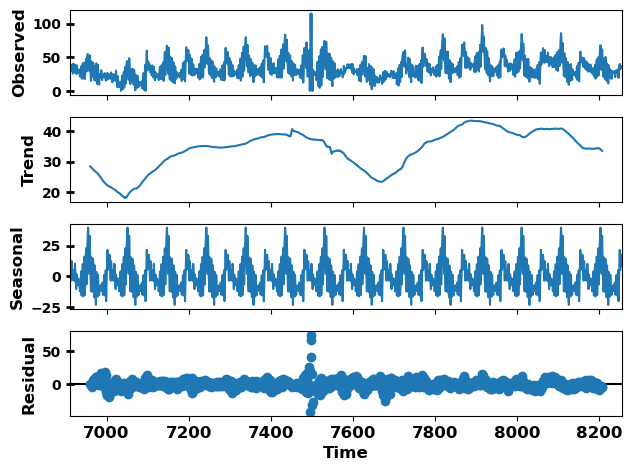

In [22]:
from matplotlib import font_manager as fm
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(analyzedata["prices"][96*7*10:96*7*12],model='additive', period=96)
fig = decompose.plot()
fig.suptitle('')
axes = fig.get_axes()
for ax, ylabel in zip(axes, ['Observed', 'Trend', 'Seasonal', 'Residual']):
    ax.set_ylabel(ylabel, fontsize=12, fontweight='bold')  # Set y-label
    labels = ax.get_yticklabels()
    ax.set_yticklabels(labels, fontproperties=fm.FontProperties(weight='bold', size=8))  # Make y-ticks bold
    
    ax.tick_params(axis='y', labelsize=10,  width=2, labelrotation=0, direction='inout', length=6, grid_alpha=0.5, labelcolor='black', colors='black')  # Set y-tick boldness
    ax.set_title("")
plt.xlabel("Time", fontsize = 12, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.title("")
plt.show()

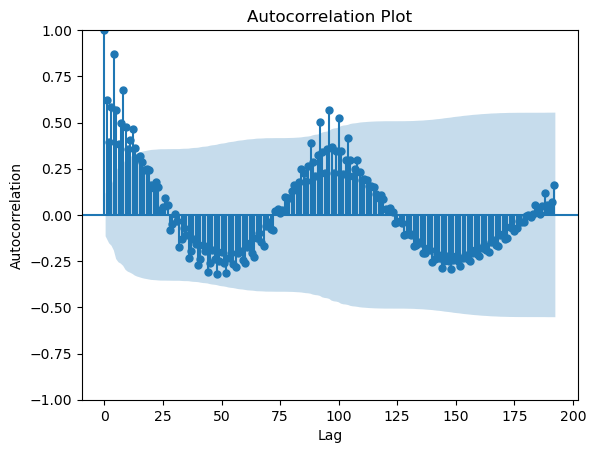

In [23]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(analyzedata["prices"][:96*3], lags=96*2)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Plot')
plt.show()

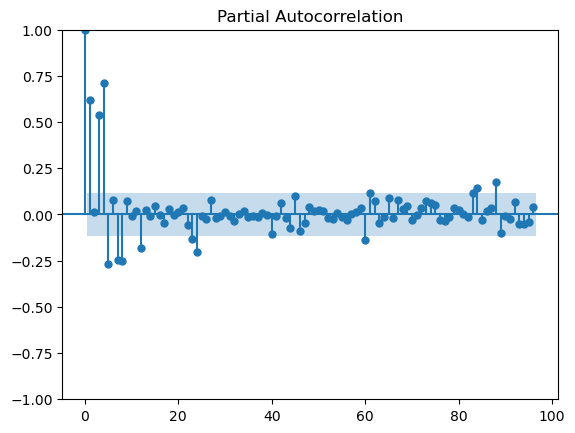

In [24]:
plot_pacf(analyzedata["prices"][:96*3],lags=96);